# Forecasting with Machine Learning

### Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

style.use('ggplot')

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None):
  plt.plot(time_[start:end], series_[start:end], label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  
  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  season_arr = np.where(season_time < 0.4, 
                        np.cos(season_time * 2 * np.pi), 
                        1 / np.exp(3 * season_time))
  return season_arr

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  seasonality_added = amplitude * seasonal_pattern(season_time)
  return seasonality_added

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  noised_arr = rnd.randn(len(time_)) * noise_level
  return noised_arr

### Data

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [0]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


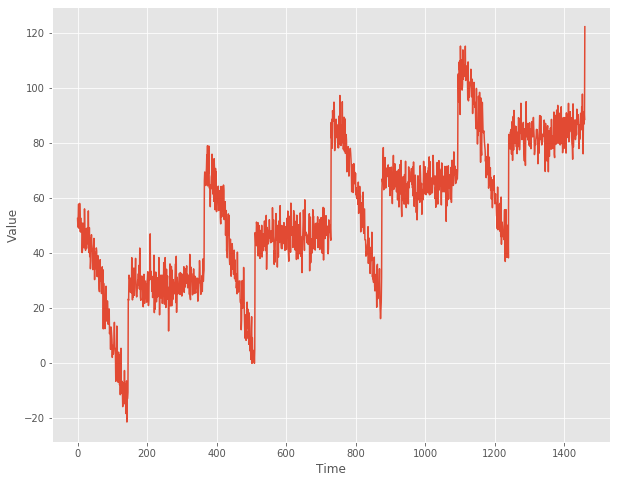

In [0]:
plt.figure(figsize=(10, 8))
plot_the_series(time_=time_, series_=series_)
plt.show()

### Training and Validation Splits

In [0]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of observations in training period   : {}".format(len(x_train)))
print("Number of observations in validation period : {}".format(len(x_valid)))

Number of observations in training period   : 1000
Number of observations in validation period : 461


## Forecasting Machine Learning

### Data Pipelines

In [0]:
def windowed_dataset(series_, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(batch_size))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)
  return dataset

In [0]:
def model_forecast(model, series_, window_size, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)
  
  forecast = model.predict(dataset)
  return forecast

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)
validation_set = windowed_dataset(series_=x_valid, window_size=window_size)

In [0]:
for feature, label in training_set.take(1):
  break

print(feature.shape)
print(label.shape)  
print("\nFeature : \n{}\nLabel : \n{}\n".format(feature, label))

(32, 30)
(32, 1)

Feature : 
[[ 68.91631323  78.85159596  63.75251065  63.47530333  64.54539987
   56.77992891  64.61632792  63.28384682  67.65466163  68.42349785
   75.89651065  71.05770114  63.20005325  61.36063214  68.06966322
   58.75557783  74.25011869  70.71560399  62.18769731  55.67276799
   70.70246271  63.04496227  69.48131243  54.98478194  59.61496863
   62.28333697  62.12776733  59.26887679  64.25051304  55.4060682 ]
 [ 31.23883496  23.80013652  22.70749832  30.45096482  26.89853122
   31.56368558  30.33829987  27.58698168  23.69675319  20.33665749
   25.65906227  32.15494132  28.92528864  21.60855625  28.6861381
   29.73035225  23.36855413  28.54108243  28.04865127  22.0284378
   29.51843418  30.52015026  33.11873199  32.96024784  20.79116199
   22.97916016  30.23273938  30.21626751  30.21284388  46.89201954]
 [ 66.73430648  62.89328365  64.97340233  71.19229531  65.72654104
   64.97488471  57.91571882  68.41920094  67.88891843  75.45196122
   63.07160705  65.68167594  65.8

## Linear Model

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

### Build the Linear Model

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=1, input_shape=[window_size])
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_1.fit(training_set, epochs=100, validation_data=validation_set)

Epoch 1/100
31/31 [==============================] - 2s 60ms/step - loss: 30.5006 - mae: 31.3173 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 8.6999 - mae: 9.1287 - val_loss: 7.6893 - val_mae: 8.2287
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 7.7296 - mae: 8.0752 - val_loss: 7.5132 - val_mae: 8.0102
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 7.4724 - mae: 7.8006 - val_loss: 7.2298 - val_mae: 7.7946
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 7.0877 - mae: 7.6197 - val_loss: 7.2710 - val_mae: 7.6113
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 7.0258 - mae: 7.4817 - val_loss: 8.1252 - val_mae: 8.5207
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 7.0061 - mae: 7.4456 - val_loss: 6.8499 - val_mae: 7.3981
Epoch 8/100
31/31 [==============================] - 0s 13ms/step 

### Which `learning_rate` should I pick?

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=1, input_shape=[window_size])
])

#### Learning Rate Scheduler

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_1.fit(training_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 21ms/step - loss: 67.5515 - mae: 68.2355
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 52.3298 - mae: 52.8279
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 34.9479 - mae: 35.3488
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 17.8159 - mae: 18.2666
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 8.5909 - mae: 9.0412
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 8.0042 - mae: 8.4686
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8518 - mae: 8.3976
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 7.9012 - mae: 8.3568
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8216 - mae: 8.3132
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 7.7424 - mae: 8.2520
Epoch 11/100
31/31 [==============================

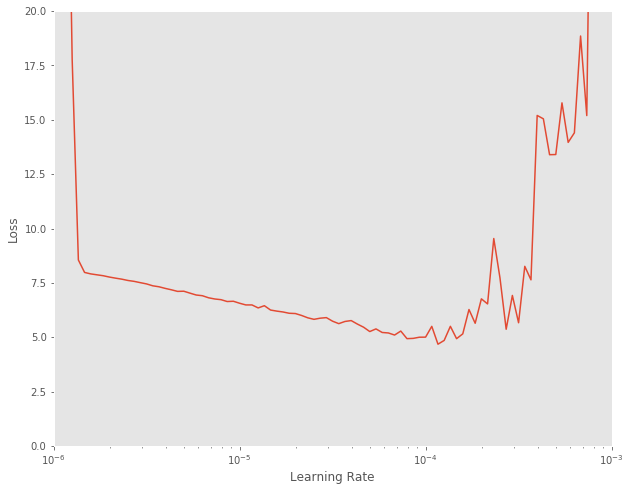

In [0]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3, 0, 20])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)
validation_set = windowed_dataset(series_=x_valid, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=1, input_shape=[window_size])
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [0]:
model_1.fit(training_set, 
            epochs=500, 
            callbacks=[early_stopping], 
            validation_data=validation_set)

Epoch 1/500
31/31 [==============================] - 1s 29ms/step - loss: 46.5854 - mae: 47.9542 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 12ms/step - loss: 11.8285 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 13ms/step - loss: 10.1682 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 9.8548 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 13ms/step - loss: 9.3782 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 9.5393 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 9.4518 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 13m

In [0]:
lin_forecast = model_forecast(model=model_1, series_=series_[split_time-window_size:-1], window_size=window_size)

In [0]:
print(lin_forecast)
print(lin_forecast.shape)

[[ 66.18348 ]
 [ 68.69587 ]
 [ 67.55318 ]
 [ 62.801834]
 [ 65.236305]
 [ 67.64525 ]
 [ 65.42919 ]
 [ 62.58561 ]
 [ 65.40356 ]
 [ 65.24559 ]
 [ 67.36516 ]
 [ 64.97948 ]
 [ 67.20979 ]
 [ 67.12482 ]
 [ 65.47185 ]
 [ 66.65917 ]
 [ 67.8038  ]
 [ 64.08554 ]
 [ 65.80576 ]
 [ 62.311684]
 [ 64.04085 ]
 [ 61.695488]
 [ 64.86429 ]
 [ 61.845627]
 [ 64.70773 ]
 [ 67.37216 ]
 [ 68.045105]
 [ 64.62648 ]
 [ 71.01697 ]
 [ 63.961113]
 [ 65.87155 ]
 [ 60.62183 ]
 [ 63.25979 ]
 [ 61.48326 ]
 [ 62.672886]
 [ 58.89588 ]
 [ 66.055756]
 [ 62.879738]
 [ 62.671837]
 [ 61.775925]
 [ 65.43407 ]
 [ 66.84816 ]
 [ 60.04928 ]
 [ 67.38495 ]
 [ 68.39328 ]
 [ 65.4771  ]
 [ 67.88324 ]
 [ 62.11526 ]
 [ 65.294136]
 [ 65.97395 ]
 [ 68.563736]
 [ 62.812595]
 [ 61.239002]
 [ 70.341255]
 [ 67.50137 ]
 [ 61.60855 ]
 [ 65.54796 ]
 [ 63.654465]
 [ 64.78506 ]
 [ 64.699844]
 [ 63.938522]
 [ 66.44963 ]
 [ 63.118935]
 [ 61.820732]
 [ 63.847057]
 [ 60.450413]
 [ 61.296196]
 [ 58.596893]
 [ 62.420364]
 [ 59.627277]
 [ 65.21321 ]
 [ 63.

In [0]:
lin_forecast_1D = lin_forecast[:, 0]

In [0]:
print(lin_forecast_1D)
print(lin_forecast_1D.shape)

[ 66.18348   68.69587   67.55318   62.801834  65.236305  67.64525
  65.42919   62.58561   65.40356   65.24559   67.36516   64.97948
  67.20979   67.12482   65.47185   66.65917   67.8038    64.08554
  65.80576   62.311684  64.04085   61.695488  64.86429   61.845627
  64.70773   67.37216   68.045105  64.62648   71.01697   63.961113
  65.87155   60.62183   63.25979   61.48326   62.672886  58.89588
  66.055756  62.879738  62.671837  61.775925  65.43407   66.84816
  60.04928   67.38495   68.39328   65.4771    67.88324   62.11526
  65.294136  65.97395   68.563736  62.812595  61.239002  70.341255
  67.50137   61.60855   65.54796   63.654465  64.78506   64.699844
  63.938522  66.44963   63.118935  61.820732  63.847057  60.450413
  61.296196  58.596893  62.420364  59.627277  65.21321   63.61951
  65.056625  66.22586   61.95308   68.32222   63.172062  58.56126
  67.3112    61.949715  68.61391   59.337955  67.17085   67.47526
  67.73667   66.78293   64.80582   68.65873   70.76955   67.42574
  64.

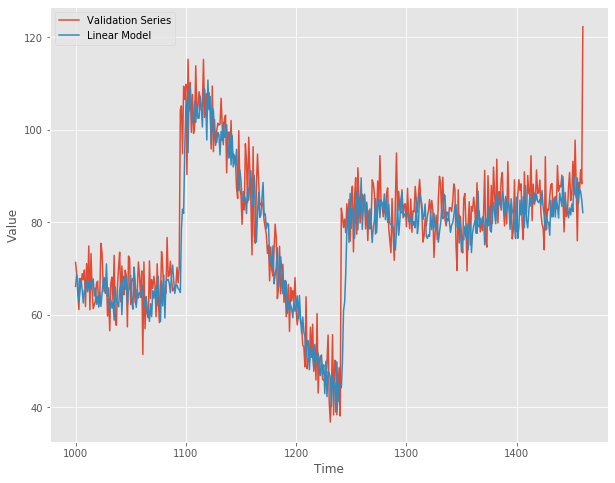

In [0]:
plt.figure(figsize=(10, 8))
plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=lin_forecast_1D, label="Linear Model")
plt.show()

In [0]:
linear_model_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=lin_forecast_1D).numpy()
print(linear_model_mae)

5.3433857


## Dense Model Forecasts

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)
validation_set = windowed_dataset(series_=x_valid, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=[window_size]), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=1)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_1.fit(training_set, epochs=100, validation_data=validation_set)

Epoch 1/100
31/31 [==============================] - 1s 36ms/step - loss: 20.0238 - mae: 20.8270 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 8.6303 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 8.1637 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 7.8828 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 7.3930 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 7.2310 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 6.9234 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/100
31/31 [==============================] - 0s 14ms/step 

### Which `learning_rate` should I pick?

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=[window_size]), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=1)
])

#### Learning Rate Scheduler

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_1.fit(training_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
31/31 [==============================] - 1s 25ms/step - loss: 43.7540 - mae: 44.3312
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 41.3856 - mae: 42.0363
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 38.7516 - mae: 39.3027
Epoch 4/200
31/31 [==============================] - 0s 10ms/step - loss: 35.7287 - mae: 36.2571
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 32.5157 - mae: 32.9531
Epoch 6/200
31/31 [==============================] - 0s 10ms/step - loss: 28.9313 - mae: 29.3875
Epoch 7/200
31/31 [==============================] - 0s 10ms/step - loss: 25.0983 - mae: 25.5689
Epoch 8/200
31/31 [==============================] - 0s 9ms/step - loss: 21.0813 - mae: 21.5282
Epoch 9/200
31/31 [==============================] - 0s 9ms/step - loss: 16.8326 - mae: 17.3206
Epoch 10/200
31/31 [==============================] - 0s 9ms/step - loss: 12.7050 - mae: 13.1887
Epoch 11/200
31/31 [==============

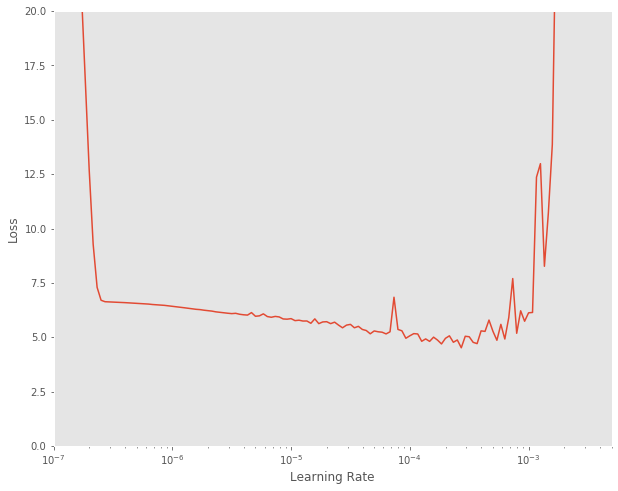

In [0]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 5e-3, 0, 20])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size)
validation_set = windowed_dataset(series_=x_valid, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=[window_size]), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=1)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [0]:
model_1.fit(training_set, 
            epochs=500, 
            callbacks=[early_stopping], 
            validation_data=validation_set)

Epoch 1/500
31/31 [==============================] - 1s 32ms/step - loss: 20.0238 - mae: 20.8270 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 8.6303 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 8.1637 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 7.8828 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 12ms/step - loss: 7.3930 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 7.2310 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 6.9234 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 12ms/step 

In [0]:
dense_forecast = model_forecast(model=model_1, 
                                series_=series_[split_time-window_size:-1], 
                                window_size=window_size)

In [0]:
print(dense_forecast)
print(dense_forecast.shape)

[[ 64.33825 ]
 [ 63.480846]
 [ 63.358078]
 [ 68.845795]
 [ 66.49291 ]
 [ 66.22238 ]
 [ 65.579414]
 [ 65.81084 ]
 [ 69.75167 ]
 [ 69.01126 ]
 [ 66.974884]
 [ 66.401146]
 [ 65.213036]
 [ 66.0358  ]
 [ 66.64521 ]
 [ 68.64681 ]
 [ 67.72185 ]
 [ 63.21529 ]
 [ 68.386215]
 [ 68.97223 ]
 [ 66.230484]
 [ 65.29062 ]
 [ 65.42502 ]
 [ 66.565094]
 [ 67.34452 ]
 [ 64.94719 ]
 [ 67.53659 ]
 [ 65.82528 ]
 [ 67.00222 ]
 [ 65.5746  ]
 [ 65.20108 ]
 [ 68.66182 ]
 [ 65.02644 ]
 [ 65.30384 ]
 [ 65.83458 ]
 [ 63.58306 ]
 [ 66.365036]
 [ 65.42412 ]
 [ 60.718037]
 [ 61.92939 ]
 [ 59.676685]
 [ 65.54422 ]
 [ 68.74765 ]
 [ 68.77079 ]
 [ 65.99136 ]
 [ 62.08218 ]
 [ 69.748024]
 [ 71.081055]
 [ 63.937477]
 [ 67.27986 ]
 [ 65.06224 ]
 [ 65.487656]
 [ 68.82091 ]
 [ 66.003235]
 [ 66.11416 ]
 [ 62.429214]
 [ 66.59334 ]
 [ 68.49935 ]
 [ 65.18079 ]
 [ 67.6103  ]
 [ 65.34419 ]
 [ 66.69529 ]
 [ 66.526375]
 [ 63.871178]
 [ 65.19811 ]
 [ 62.631073]
 [ 63.076847]
 [ 63.952953]
 [ 64.14781 ]
 [ 62.228615]
 [ 63.298573]
 [ 67.

In [0]:
dense_forecast_1D = dense_forecast[:, 0]

In [0]:
print(dense_forecast_1D)
print(dense_forecast_1D.shape)

[ 64.33825   63.480846  63.358078  68.845795  66.49291   66.22238
  65.579414  65.81084   69.75167   69.01126   66.974884  66.401146
  65.213036  66.0358    66.64521   68.64681   67.72185   63.21529
  68.386215  68.97223   66.230484  65.29062   65.42502   66.565094
  67.34452   64.94719   67.53659   65.82528   67.00222   65.5746
  65.20108   68.66182   65.02644   65.30384   65.83458   63.58306
  66.365036  65.42412   60.718037  61.92939   59.676685  65.54422
  68.74765   68.77079   65.99136   62.08218   69.748024  71.081055
  63.937477  67.27986   65.06224   65.487656  68.82091   66.003235
  66.11416   62.429214  66.59334   68.49935   65.18079   67.6103
  65.34419   66.69529   66.526375  63.871178  65.19811   62.631073
  63.076847  63.952953  64.14781   62.228615  63.298573  67.29218
  63.893116  62.94224   63.56242   64.76184   68.29578   62.235764
  65.578865  66.65409   64.16278   70.47914   66.6018    63.705917
  62.847256  64.84392   71.32298   68.437256  66.85033   68.076126
  67

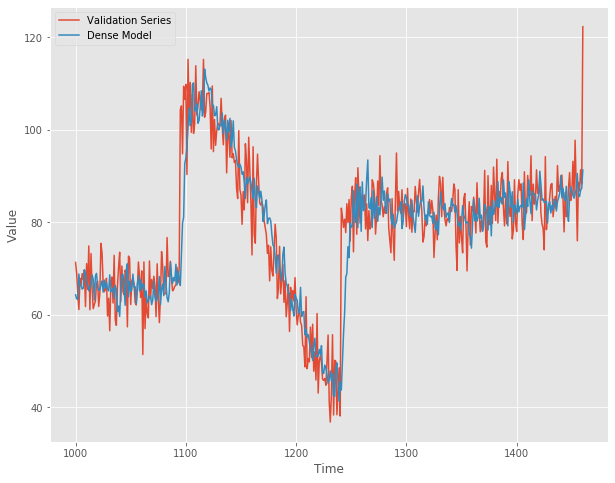

In [0]:
plt.figure(figsize=(10, 8))
plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=dense_forecast_1D, label="Dense Model")
plt.show()

In [0]:
dense_model_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=dense_forecast_1D).numpy()
print(dense_model_mae)

5.299474
